In [3]:
%matplotlib inline
import numpy as np
import cv2
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from lesson_functions import *

from sklearn.metrics import accuracy_score, f1_score, make_scorer
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC



In [4]:
vehicles=glob.glob('data/vehicles/*/*')
non_vehicles=glob.glob('data/non-vehicles//*/*')

all_images=np.concatenate([vehicles,non_vehicles])
y=np.array([1 for i in vehicles]+[0 for i in non_vehicles],dtype=np.uint8)
folder=[a.split('/')[2] for a in all_images]
#images=np.array([cv2.imread(a) for a in all_images])

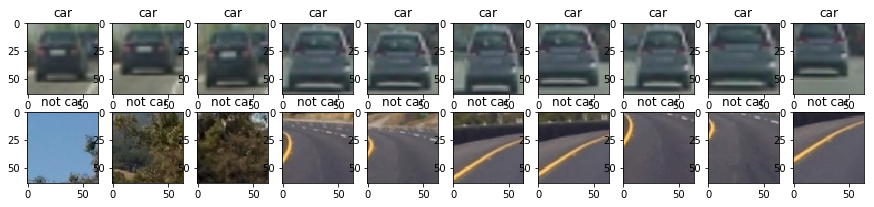

In [38]:
fig, ax = plt.subplots(2,10)
fig.set_figwidth(15)
fig.set_figheight(3)

for i in range(10):
    ax[0][i].imshow(mpl.image.imread(all_images[np.where(y==1)[0][i]]))
    ax[1][i].imshow(mpl.image.imread(all_images[np.where(y==0)[0][i]]))
    
    ax[0][i].set_title('car')
    ax[1][i].set_title('not car')


plt.savefig('output_images/examples.png')


In [6]:
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

# we will extract hog features for all channels using parametres below

In [7]:
from tqdm import tqdm_notebook
import os


color_space =  'RGB'#, 'HSV', 'LUV', 'HLS', 'YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
color_spaces=['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

if os.path.exists('all_features.npy'):
    all_features=np.load('all_features.npy')
else:
    images=np.array([cv2.imread(a) for a in all_images])
    all_features=np.array([extract_features(images, color_space=sp, 
                       spatial_size=spatial_size, hist_bins=hist_bins, 
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, 
                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                       hist_feat=hist_feat, hog_feat=hog_feat, preprocessing=False,from_file=False) for sp in \
              tqdm_notebook(color_spaces)])
    del(images)
    np.save('all_features.npy',all_features)
    

The installed widget Javascript is the wrong version.
/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# todo - normal train/test split (see and the bottom of notebook)

In [9]:
color_spaces=['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

preds=np.zeros((len(color_spaces),len(y)),dtype=np.uint8)
preds2=np.zeros((len(color_spaces),len(y)),dtype=np.uint8)


pl=Pipeline([ \
             ('scalar',StandardScaler()), \
            ('svc',LinearSVC())])

res=[]
preds=np.zeros((len(color_spaces),len(y)),dtype=np.uint8)

for i in tqdm_notebook(range(len(color_spaces)),desc='colorspace'):
        z=all_features[i].copy()
        z[np.isnan(z)]=0
        cv=skf.split(z,y)
        for a,b in cv:
            pl=Pipeline([ \
             ('scalar',StandardScaler()), \
             ('svm',LinearSVC())])
            pl.fit(z[a], y[a])
            pred=pl.predict(z[b])
            res.append([accuracy_score(y[b],pred), f1_score(y[b],pred)])
            preds[i][b]=pred
        
        print (color_spaces[i], np.mean(res,axis=0))


The installed widget Javascript is the wrong version.


RGB [ 0.98485365  0.98464794]
HSV [ 0.98845719  0.9883061 ]
LUV [ 0.99005259  0.98992389]
HLS [ 0.99042796  0.99030675]
YUV [ 0.99092346  0.99080963]
YCrCb [ 0.99121628  0.99110656]



In [39]:
#looking at ensemble - the best score
print ('Ensembling score:', f1_score(y,np.median(preds,axis=0).astype(np.uint8)))

Ensembling score: 0.99446315429


# thus - the best model was for YCrCb - it has accurancy 0.99 and f1 0.991 - I hope it will be enough for this project. Anyway, using ensemble (just voting everage) of all models gives us much better score (0.994) and it coult be calculated in parallel - so if we need we will use it

## let's se how hog features difs for car and for not car

In [52]:
all_images[np.where(y==0)[0][1]]

'data/non-vehicles/Extras/extra10.png'

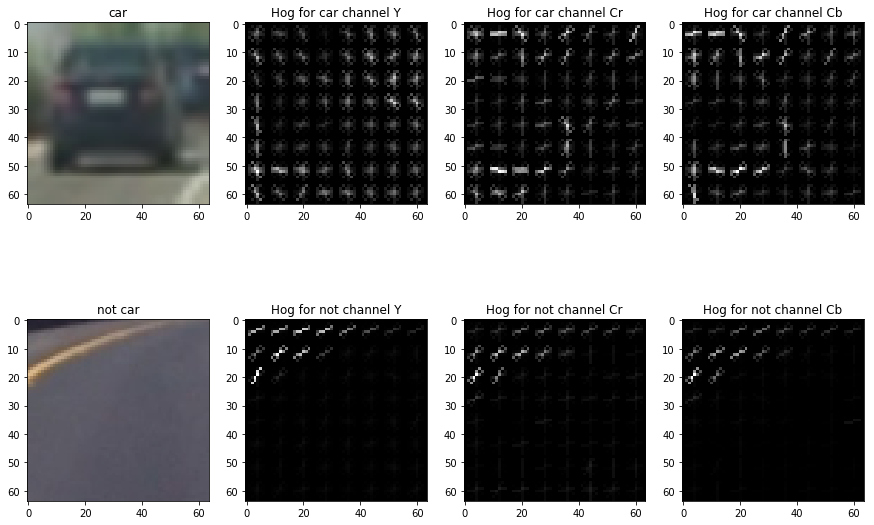

In [69]:
fig, ax = plt.subplots(2,4)
fig.set_figwidth(15)
fig.set_figheight(10)


ax[0][0].imshow(mpl.image.imread(all_images[np.where(y==1)[0][0]]))
ax[1][0].imshow(mpl.image.imread(all_images[np.where(y==0)[0][100]]))

ax[0][0].set_title('car')
ax[1][0].set_title('not car')

car=cv2.cvtColor(cv2.imread(all_images[np.where(y==0)[0][1]]),cv2.COLOR_BGR2YCrCb)
not_car=cv2.cvtColor(cv2.imread(all_images[np.where(y==0)[0][100]]),cv2.COLOR_BGR2YCrCb)


colors=['Y','Cr','Cb']

for i in range(3):
    car=cv2.cvtColor(cv2.imread(all_images[np.where(y==0)[0][1]]),cv2.COLOR_BGR2YCrCb)
    tmp,car_hog= get_hog_features(car[:,:,i],\
                                orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \
                                vis=True, feature_vec=True)

    tmp,notcar_hog= get_hog_features(not_car[:,:,i] ,\
                                orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \
                                vis=True, feature_vec=True)

    ax[0][i+1].imshow(car_hog, cmap='gray')
    ax[1][i+1].imshow(notcar_hog, cmap='gray')
    ax[0][i+1].set_title('Hog for car channel %s' % colors[i])
    ax[1][i+1].set_title('Hog for not channel %s' % colors[i])

plt.savefig('output_images/hog.png')
plt.show()

# now let's train SVM for all colorspaces on full dataset

In [11]:
import pickle
if os.path.exists('clf.pk1'):
    with open('clf.pk1','rb') as f:
        pls=pickle.load(f)
else:
    
    pls=[Pipeline([ \
                 ('scalar',StandardScaler()), \
                 ('svm',LinearSVC())]) for i in range(len(color_spaces))]

    for i in tqdm_notebook(range(len(color_spaces))):
        z=all_features[i]
        z[np.isnan(z)]=0
        pls[i].fit(z,y)
        
    with open('clf.pk','wb') as f:
        pickle.dump(pls,f,-1)
        

The installed widget Javascript is the wrong version.


# next goal is to make function, which will make hog transformation of whole image and then take hog features just of the needed part. 

# our function will take an part of image (from ystart to ystop) than scale it (we've scale variable) and than calculate needed number of "boxes" with fixed step measured in hog's cell (it's needed because we are going to calculate hog only once)

In [60]:
def get_features(img, ystart, ystop, scale, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size,
              hist_bins, heatmap=None,heat_thresh=3,cells_per_step = 2):
     
    img_tosearch = img[ystart:ystop, :, :]
    if color_space != 'RGB':
            if color_space == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
    
    
    imshape = ctrans_tosearch.shape
    ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - 1
    
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog=np.array([get_hog_features(ctrans_tosearch[:,:,i], orient, pix_per_cell, cell_per_block, feature_vec=False)\
                for i in range(3)])
    
    features=[]
    boxes=[]
    
    window_size=int(window*scale)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos,ypos = xb * cells_per_step, yb * cells_per_step
            xleft, ytop = xpos * pix_per_cell,  ypos * pix_per_cell
            x, y = int(xleft*scale), int(ytop*scale)
            
            box= ((x,y+ystart),(x+window_size,y+window_size+ystart))
            #print (box)
            if heatmap!=None and heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]].max()<heat_thresh:
                continue
            
            # Extract HOG for this patch
            hog_features = np.hstack([hog[i,ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()\
                                     for i in range(3)])
       
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # concatenate features
            features.append(np.hstack((spatial_features, hist_features, hog_features)))
            boxes.append(box)
            
   
    return np.array(features),boxes
    


# let's look how our bounding boxes looks. we will use them for scales 1,1.5 and 2

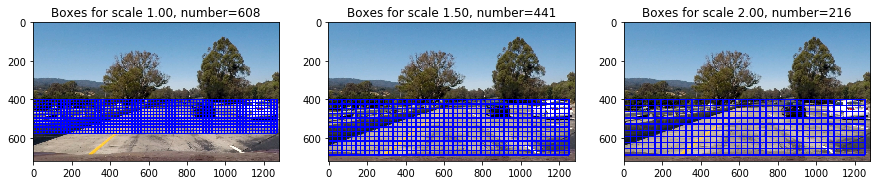

In [65]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)
img = mpimg.imread('test_images/test1.jpg')

for i, (scale,ystart,ystop) in enumerate(((1,400,600),(1.5,400,720),(2,400,720))):
    feature,bbox=get_features(img, scale=scale, ystart=ystart, ystop=ystop, color_space=color_spaces[-1],\
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \
                              hog_channel=hog_channel, \
                              spatial_size=spatial_size, hist_bins=hist_bins)
    ax[i].imshow(draw_boxes(img,bbox))
    ax[i].set_title('Boxes for scale %.2f, number=%d' %(scale,len(bbox)))
plt.savefig('output_images/bbox.png')
plt.show()

# this are modified functions from the lesson. calculating heat, calculating label boxes and visualization of them

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bboxes=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return bboxes

def get_heat (image, box_list, threshhold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)


    # Add heat to each box in box list
    heat = add_heat(heat,box_list)


    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshhold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    return heatmap

def get_labels(image, heatmap,label_threshhold=3, verbose=False):
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    labeled_boxes=get_labeled_bboxes(labels)
    #print (labeled_boxes)
    

    good_labels=[a for a in labeled_boxes if heatmap[a[0][1]:a[1][1],a[0][0]:a[1][0]].max()>label_threshhold]
    
    draw_img = draw_boxes(np.copy(image), good_labels)
    return  draw_img

# it's possible to calculate everything needed using multiprocessing pool, but for now we will leave it in single process

In [66]:
def get_features2(params):
    return get_features(**params)

# we will use theshold 1 for heatmaps - we can see that heatmap and labels are good

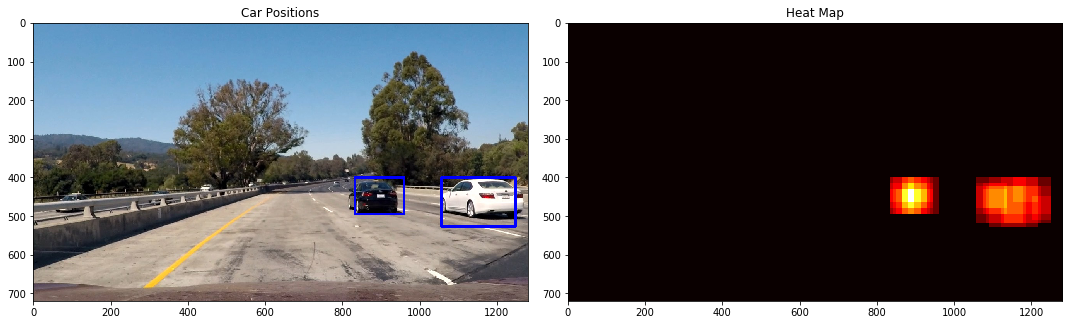

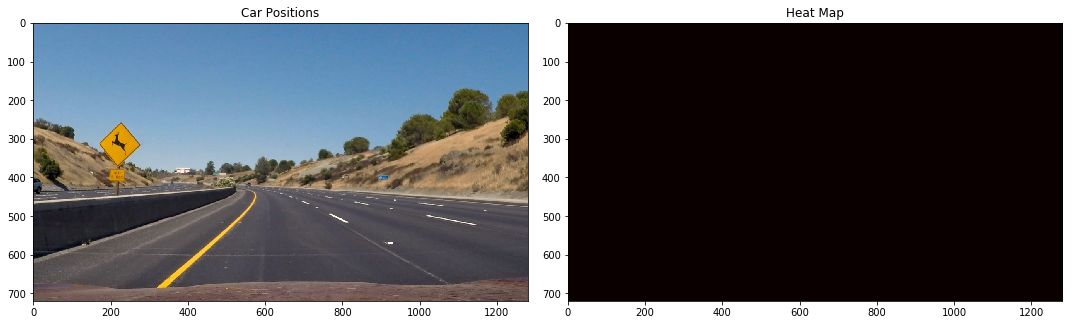

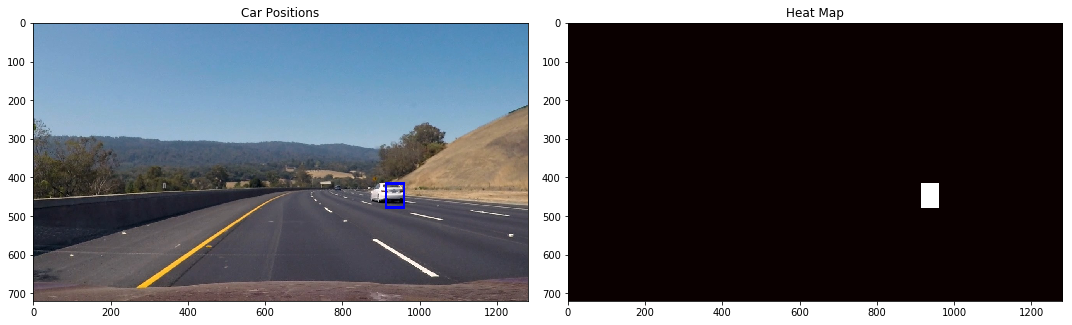

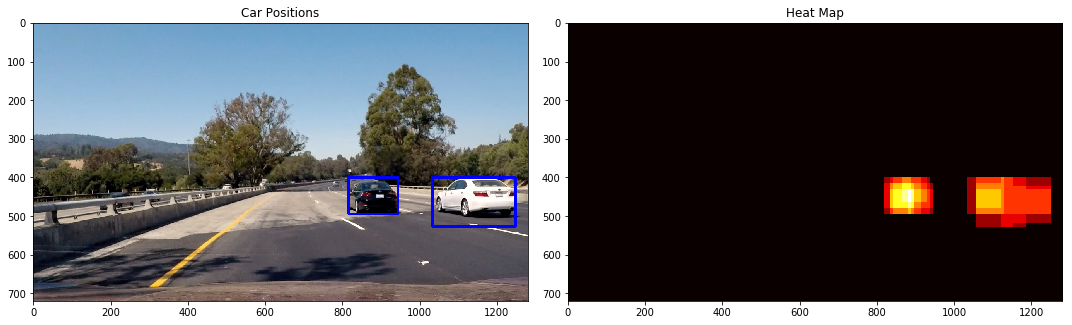

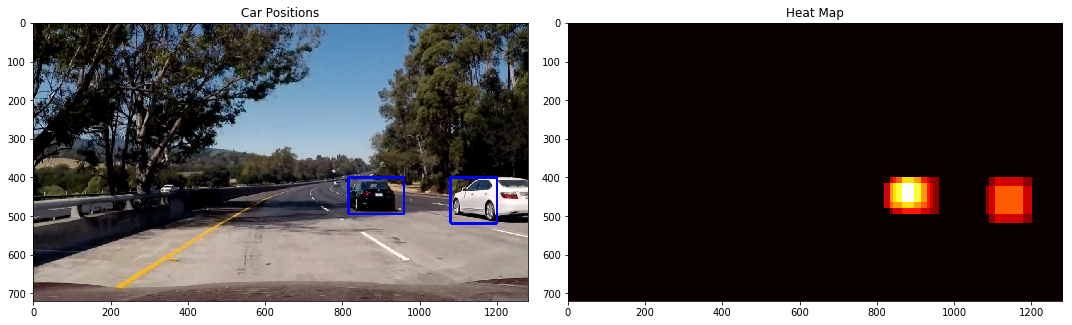

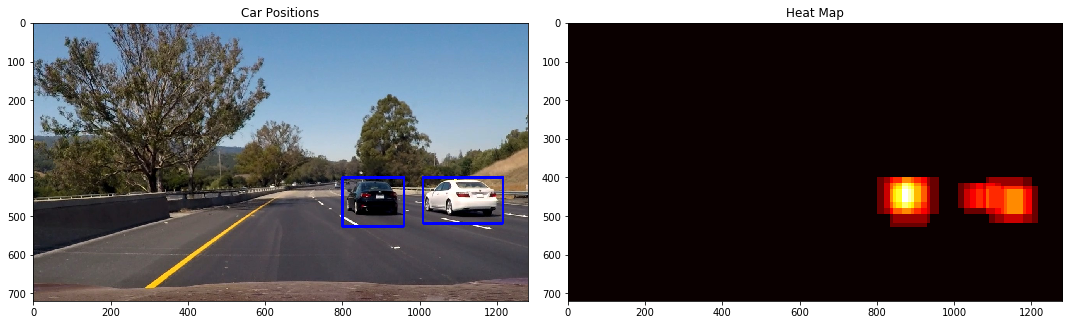

In [67]:
import pickle 

## Load model params
svc=pls[-1]

gl=glob.glob('test_images/*.jpg')
for fname in gl:
    img = mpimg.imread(fname)


    ystart = 400
    ystop = 720
    scale = 1

    i=-1
    color_space=color_spaces[i]
    features, bboxes=[],[]
    
    params=[{'img':img,
    'ystart':ystart,
    'ystop':ystop,
    'scale':scale,
    'color_space':color_spaces[-1],
    'orient':orient,
    'pix_per_cell':pix_per_cell,
    'cell_per_block':cell_per_block,
    'hog_channel':hog_channel,
    'spatial_size':spatial_size,
    'hist_bins':hist_bins,
    'heatmap':None,
    'heat_thresh':3} for scale,ystart,ystop in ((1,400,600),(1.5,400,720),(2,400,720))]
    
    r=[get_features2(a) for a in params]#mpool.map(get_features2,params)
    
    pred=pls[i].predict(np.concatenate([a[0] for a in r]))
    
    for a in r:
        bboxes.extend(a[1])
    
    good_boxes=[bboxes[i] for i in range(len(bboxes)) if pred[i]]

    heatmap=  get_heat  (img,good_boxes,1)
    labels=   get_labels(img, heatmap,1)
    
    fig = plt.figure(figsize=(15,5))


    plt.subplot(121)
    plt.imshow(labels)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.savefig('output_images/%s' % fname.replace('test_images/',''))
    plt.show()

# the last thing is to use information about previous car location to avoid false negatives. we will use median of last 5 got heatmaps for drawing labels - so object have to be at least at 3 heatmaps from 5 to be drawn

In [35]:
class car_detector:
    def __init__(self):
        self.heatmaps=[]
        self.images=[]
        self.iter=-1
        self.prev=None
    def process_img(self, img):
        #self.images.append(img)
        self.iter+=1
        cv2.imwrite('video/%d.png' % self.iter,img)
        
        
        features, bboxes=[],[]

        
        params=[{'img':img,
        'ystart':ystart,
        'ystop':ystop,
        'scale':scale,
        'color_space':color_spaces[-1],
        'orient':orient,
        'pix_per_cell':pix_per_cell,
        'cell_per_block':cell_per_block,
        'hog_channel':hog_channel,
        'spatial_size':spatial_size,
        'hist_bins':hist_bins,
        'heatmap':None,
        'heat_thresh':3} for scale,ystart,ystop in ((1,400,600),(1.5,400,720),(2,400,720))]

        r=[get_features2(a) for a in params]#mpool.map(get_features2,params)
    

        pred=pls[i].predict(np.concatenate([a[0] for a in r]))

        for a in r:
            bboxes.extend(a[1])

        good_boxes=[bboxes[i] for i in range(len(bboxes)) if pred[i]]


        heatmap=  get_heat  (img,good_boxes,0)
        self.heatmaps.append(heatmap)
        
        h=np.median(self.heatmaps[-5:],axis=0)
        h[np.where(h<=1)]=0
        labels=   get_labels(img, h,1)
        self.prev=labels
        return labels
        

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l=car_detector()
videofile='test_video.mp4'

clip1 = VideoFileClip(videofile)
white_clip = clip1.fl_image(l.process_img) #NOTE: this function expects color images!!
white_clip.write_videofile(videofile.replace('video','anotated'), audio=False)

[MoviePy] >>>> Building video test_anotated.mp4
[MoviePy] Writing video test_anotated.mp4


 97%|█████████▋| 38/39 [00:43<00:01,  1.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_anotated.mp4 



In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l=car_detector()
videofile='project_video.mp4'

clip1 = VideoFileClip(videofile)
white_clip = clip1.fl_image(l.process_img) #NOTE: this function expects color images!!
white_clip.write_videofile(videofile.replace('video','anotated'), audio=False)

[MoviePy] >>>> Building video project_anotated.mp4
[MoviePy] Writing video project_anotated.mp4



100%|█████████▉| 1260/1261 [24:25<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_anotated.mp4 



# we are done :)